In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import random
import shutil
import albumentations as A
from tqdm import tqdm
from shutil import copy2

# Load Data

In [3]:
DATA_DIR = "/kaggle/input/elpraw/Data"
OUTPUT_DIR = "/kaggle/working/augmented_data"
TEST_DIR = os.path.join(OUTPUT_DIR, "test")
TRAIN_DIR = os.path.join(OUTPUT_DIR, "train")
SPLIT_COUNT = 35
SEED = 42

In [4]:
class_map = {
    "1_Private_Blue": "Blue",
    "2_Taxi_Orange": "Orange",
    "3_Commercial_Red": "Red",
    "4_PublicTransport_Grey": "Grey",
    "5_Diplomats_Green": "Green",
    "6_TouristTemporary_Yellow": "Yellow"
}

In [5]:
random.seed(SEED)

os.makedirs(TEST_DIR, exist_ok=True)
os.makedirs(TRAIN_DIR, exist_ok=True)

In [7]:
data_summary = []
for folder_name, color_name in class_map.items():
    cls_path = os.path.join(DATA_DIR, folder_name)
    if os.path.isdir(cls_path):
        num_images = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    else:
        num_images = 0
    data_summary.append({"Folder": folder_name, "Color": color_name, "Count": num_images})

df = pd.DataFrame(data_summary).sort_values("Color").reset_index(drop=True)
print("===== Dataset Summary (before augment) =====")
print(df[["Color", "Count"]])

===== Dataset Summary (before augment) =====
    Color  Count
0    Blue   1219
1   Green    193
2    Grey    131
3  Orange    348
4     Red    239
5  Yellow    141


# Class Distribution

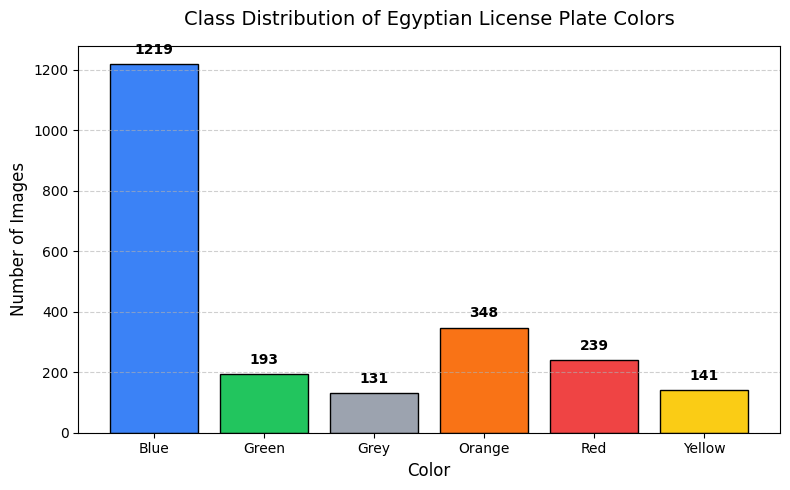

In [8]:
color_map = {
    "Blue": "#3b82f6",
    "Orange": "#f97316",
    "Red": "#ef4444",
    "Grey": "#9ca3af",
    "Green": "#22c55e",
    "Yellow": "#facc15"
}

plt.figure(figsize=(8, 5))
plt.bar(df["Color"], df["Count"],
        color=[color_map[c] for c in df["Color"]],
        edgecolor="black")

for i, v in enumerate(df["Count"]):
    plt.text(i, v + max(df["Count"])*0.02, str(v), ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.title("Class Distribution of Egyptian License Plate Colors", fontsize=14, pad=15)
plt.xlabel("Color", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Data Augmentation

In [9]:
for folder_name, color_name in class_map.items():
    src_dir = os.path.join(DATA_DIR, folder_name)
    images = [f for f in os.listdir(src_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    random.shuffle(images)
    
    test_class_dir = os.path.join(TEST_DIR, color_name)
    train_class_dir = os.path.join(TRAIN_DIR, color_name)
    os.makedirs(test_class_dir, exist_ok=True)
    os.makedirs(train_class_dir, exist_ok=True)
    
    test_imgs = images[:SPLIT_COUNT]
    for img_name in test_imgs:
        shutil.copy(os.path.join(src_dir, img_name), os.path.join(test_class_dir, img_name))
    
    train_imgs = images[SPLIT_COUNT:]
    for img_name in train_imgs:
        shutil.copy(os.path.join(src_dir, img_name), os.path.join(train_class_dir, img_name))

print("Test/train split done.")

Test/train split done.


In [10]:
augment = A.Compose([
    A.Rotate(limit=7, border_mode=cv2.BORDER_REFLECT, p=0.5), 
    A.HorizontalFlip(p=0.3),
    A.RandomScale(scale_limit=0.1, p=0.3),                     
    A.RandomBrightnessContrast(brightness_limit=0.02, contrast_limit=0.02, p=0.3)
])

In [11]:
TARGET = 600

for color_name in class_map.values():
    train_class_dir = os.path.join(TRAIN_DIR, color_name)
    augmented_dir = os.path.join(OUTPUT_DIR, "train_aug", color_name)
    os.makedirs(augmented_dir, exist_ok=True)
    
    images = [f for f in os.listdir(train_class_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    n_existing = len(images)
    
    for img_file in images:
        shutil.copy(os.path.join(train_class_dir, img_file),
                    os.path.join(augmented_dir, img_file))
    
    if color_name == "Blue":
        continue
    
    n_to_augment = TARGET - n_existing
    for i in tqdm(range(n_to_augment), desc=f"Augmenting {color_name}"):
        img_file = random.choice(images)  
        img = cv2.imread(os.path.join(train_class_dir, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        aug_img = augment(image=img)['image']
        save_path = os.path.join(augmented_dir, f"{os.path.splitext(img_file)[0]}_aug{i}.jpg")
        cv2.imwrite(save_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

print("Augmentation done.")

Augmenting Yellow: 100%|██████████| 494/494 [00:00<00:00, 1099.07it/s]

Augmentation done.


In [12]:
def get_distribution(folder, class_map):
    data_summary = []
    for folder_name, color_name in class_map.items():
        cls_path = os.path.join(folder, color_name)
        if os.path.isdir(cls_path):
            num_images = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        else:
            num_images = 0
        data_summary.append({"Color": color_name, "Count": num_images})
    df = pd.DataFrame(data_summary).sort_values("Color").reset_index(drop=True)
    return df

print("===== Test Set Distribution =====")
test_df = get_distribution(TEST_DIR, class_map)
print(test_df)

print("\n===== Train Set Distribution (after augmentation) =====")
train_aug_dir = os.path.join(OUTPUT_DIR, "train_aug")
train_df = get_distribution(train_aug_dir, class_map)
print(train_df)

===== Test Set Distribution =====
    Color  Count
0    Blue     35
1   Green     35
2    Grey     35
3  Orange     35
4     Red     35
5  Yellow     35

===== Train Set Distribution (after augmentation) =====
    Color  Count
0    Blue   1184
1   Green    600
2    Grey    600
3  Orange    600
4     Red    600
5  Yellow    600


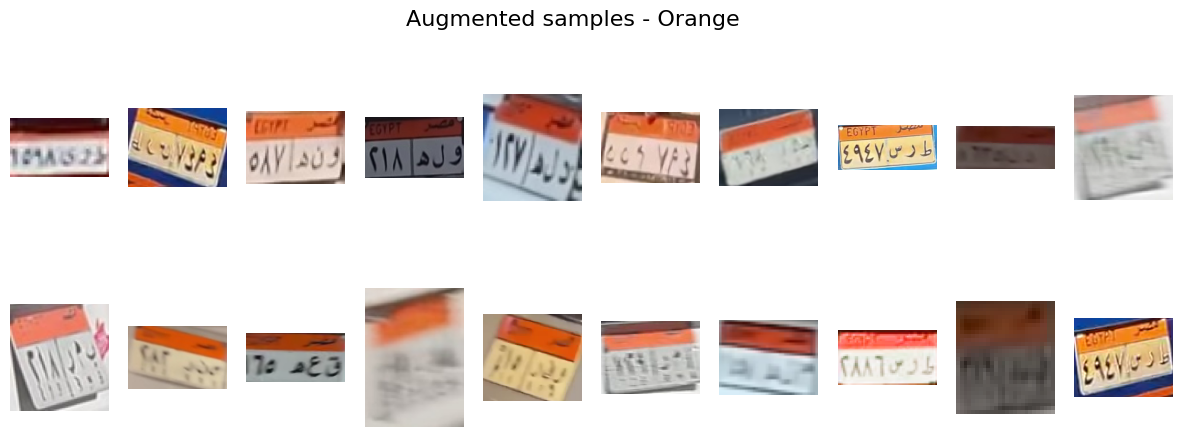

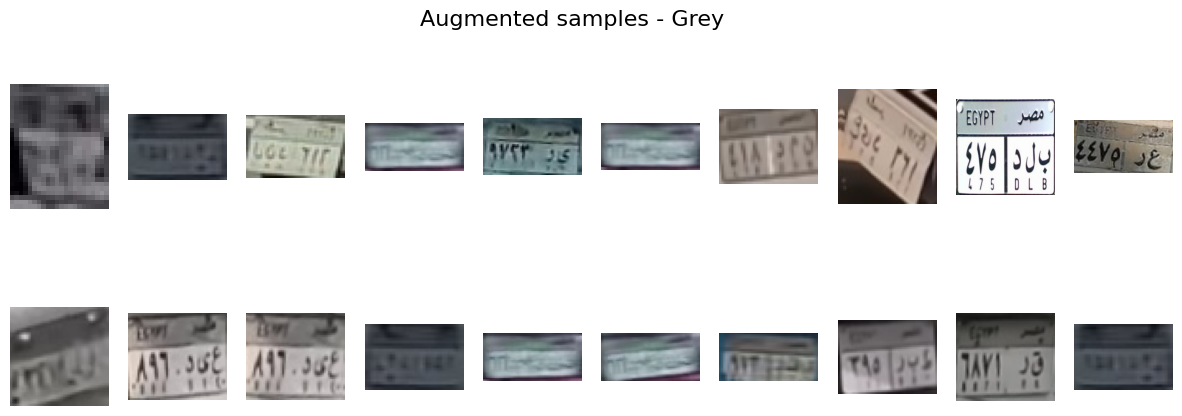

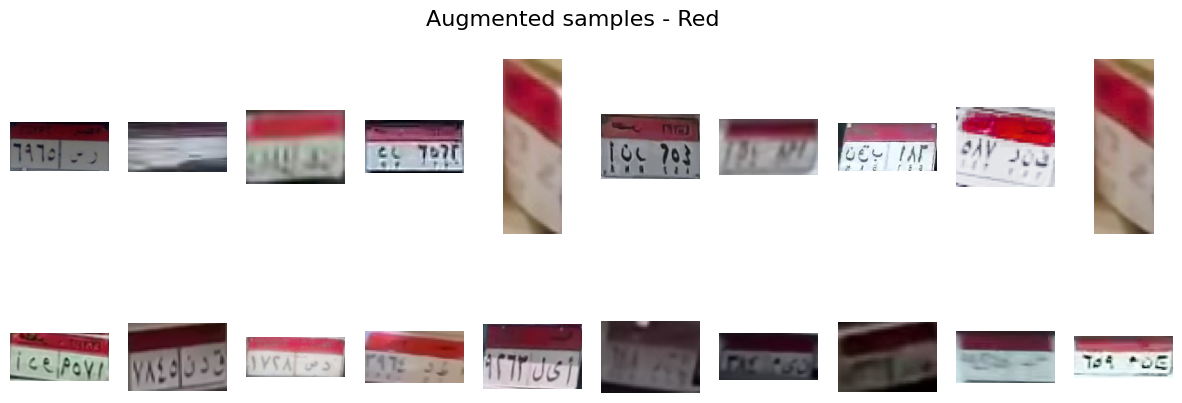

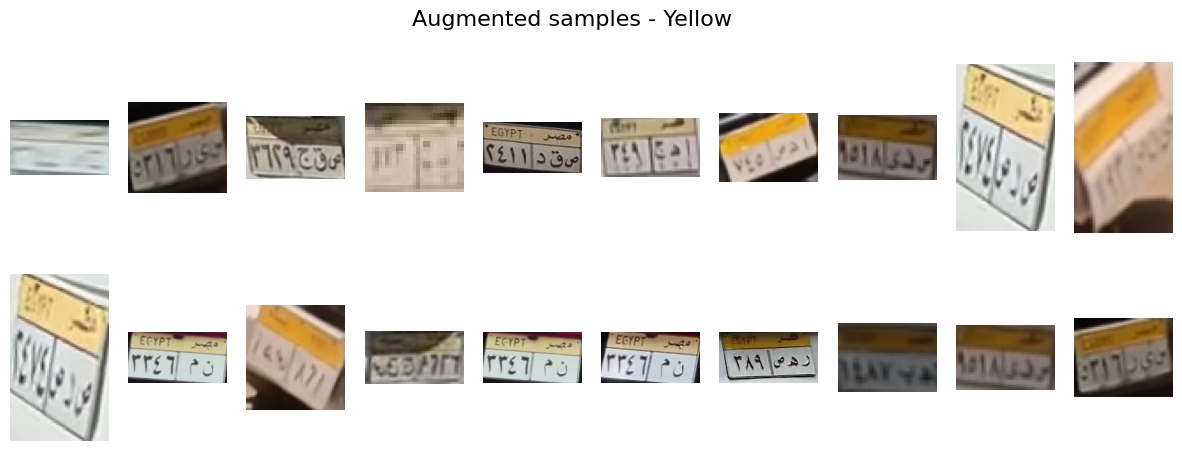

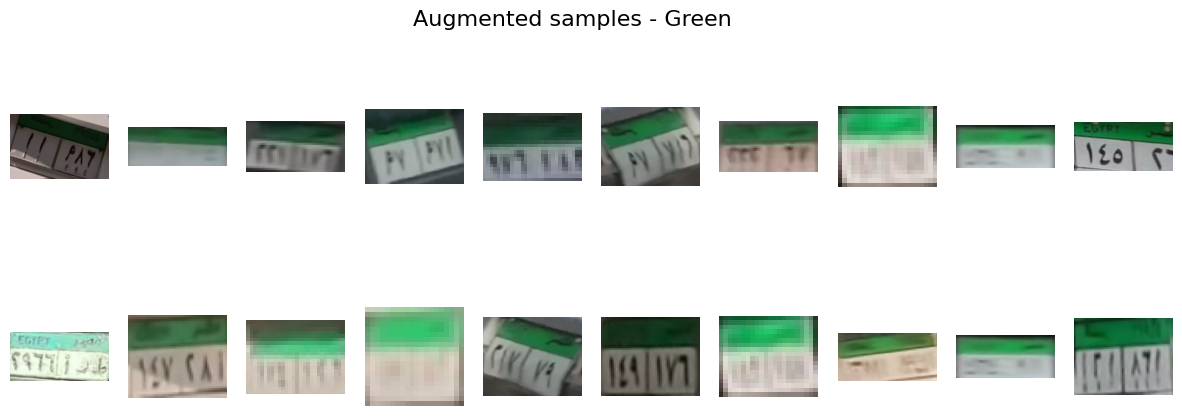

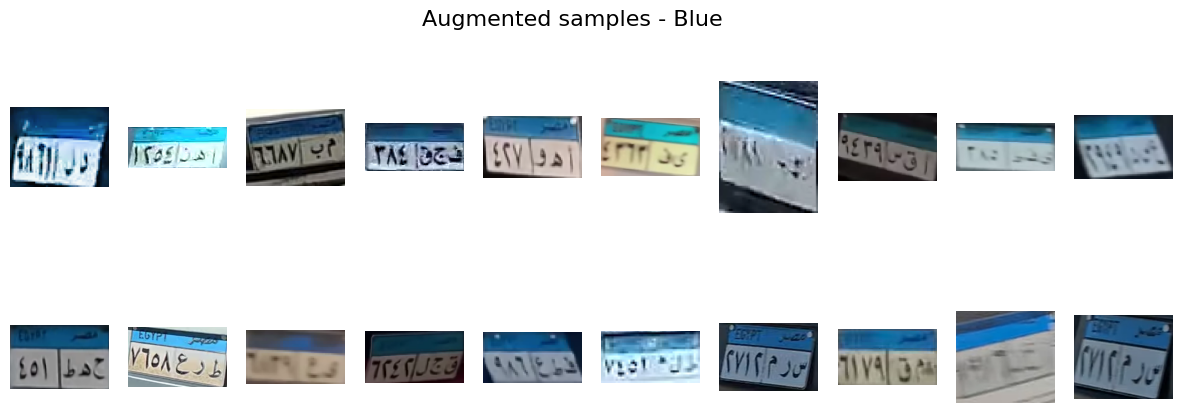

In [14]:
SAMPLES_TO_DISPLAY = 20
train_aug_dir = "/kaggle/working/augmented_data/train_aug"

for color_name in os.listdir(train_aug_dir):
    class_dir = os.path.join(train_aug_dir, color_name)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    selected = random.sample(images, min(SAMPLES_TO_DISPLAY, len(images)))
    
    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(selected):
        img_path = os.path.join(class_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(2, 10, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Augmented samples - {color_name}", fontsize=16)
    plt.show()

In [13]:
dataset_dir = "/kaggle/working/augmented_data"
zip_path = "/kaggle/working/augmented_data.zip"
shutil.make_archive(base_name=zip_path.replace(".zip",""), format='zip', root_dir=dataset_dir)

'/kaggle/working/augmented_data.zip'